In [1]:
from tensorflow.keras import layers, activations
import tensorflow_datasets as tfds
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np

import time


ds = tfds.load('svhn_cropped', split='train', as_supervised=True, shuffle_files=True)

In [2]:
def normalize_img(image, label):
    return (tf.cast(image, tf.float32) - 127.5) / 127.5, label

def map_fn(image, label):
    return (tf.reshape(image, [-1]), label)

ds = ds.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds = ds.map(
    map_fn, num_parallel_calls=tf.data.AUTOTUNE)

ds = ds.batch(256)
ds = ds.cache()
ds = ds.shuffle(80000, reshuffle_each_iteration=True)
ds = ds.prefetch(tf.data.AUTOTUNE)
z = 128

## Atividades



2. (4.0 pontos) Com base na arquitetura implementada na questão 1, construa uma **GAN condicional** para gerar imagens condicionadas aos rótulos.

* Plote a função de custo do gerador e do discriminador e o divergente de Jensen-Shannon ao longo das épocas;

* Ao final do treino, avalie os exemplos gerados usando a métrica Fréchet Inception Distance (FID);

* Plote um grid com alguns exemplos gerados e seus respectivos rótulos.

Analise criticamente os resultados (Escreva 1-2 parágrafos sobre os resultados).

In [3]:
def make_cgan_generator_model():
    input_ = layers.Input(shape=(z,))
    condition = layers.Input(shape=(1,))
    e_condition = layers.Embedding(10, z)(condition)
    e_condition = layers.Flatten()(e_condition)
    x = layers.multiply([input_, e_condition])

    x = layers.Dense(128)(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    
    x = layers.Dense(256)(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Dense(512)(x)
    x = layers.LeakyReLU(0.2)(x)
    
    out = layers.Dense(32*32*3, activation="tanh")(x)

    model = tf.keras.Model([input_, condition], out, name="generator")
    return model

In [4]:
def make_cgan_discriminator_model():
    input_ = layers.Input(shape=(32*32*3,))
    condition = layers.Input(shape=(1,))
    e_condition = layers.Embedding(10, 32*32*3)(condition)
    e_condition = layers.Flatten()(e_condition)
    x = layers.multiply([input_, e_condition])
    
    x = layers.Dense(1024)(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Dense(512)(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Dense(256)(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Dropout(0.3)(x)
    
    
    out = layers.Dense(1, activation="sigmoid")(x)
    model = tf.keras.Model([input_, condition], out, name="discriminator")

    return model

In [5]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = (real_loss + fake_loss) *0.5
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(3e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(3e-4)


In [6]:
EPOCHS = 250
BATCH_SIZE = 256


@tf.function
def train_step_cgan(images, labels):
    noise = tf.random.normal([labels.shape[0], z])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator([noise, labels], training=True)
        real_output = discriminator([images, labels], training=True)
        fake_output = discriminator([generated_images, labels], training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [7]:
generator = make_cgan_generator_model()
discriminator = make_cgan_discriminator_model()

gen_images = []
seed = tf.random.normal([10, z])

g_loss = []
d_loss = []
def train_cgan(dataset, epochs):
    count = 0
    for epoch in range(epochs):
        g = []
        d = []
        for image_batch in dataset:
            gen_loss, disc_loss = train_step_cgan(image_batch[0], image_batch[1])
            g.append(gen_loss.numpy())
            d.append(disc_loss.numpy())
        g_loss.append(np.average(g))
        d_loss.append(np.average(d))
            
        count += 1
        if count == EPOCHS//10:
            count = 0
            gen_images.append(generator([seed, np.arange(0, 10)]).numpy().reshape(-1, 32, 32, 3))
            print("g_loss: {}, d_loss: {}".format(np.average(g), np.average(d)))

        
a = time.time()
train_cgan(ds, EPOCHS)
print(time.time() - a)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
g_loss: 6.377439975738525, d_loss: 0.09077876806259155
g_loss: 2.764265298843384, d_loss: 0.2419784963130951
g_loss: 1.9495577812194824, d_loss: 0.3720753490924835
g_loss: 1.8478995561599731, d_loss: 0.34609001874923706
g_loss: 1.5087038278579712, d_loss: 0.4209538996219635
g_loss: 1.5351635217666626, d_loss: 0.49667221307754517
g_loss: 1.3518857955932617, d_loss: 0.4630596935749054
g_loss: 1.3034567832946777, d_loss: 0.5103355646133423
g_loss: 1.313493013381958, d_loss: 0.5192828178405762
g_loss: 1.1942058801651, d_loss: 0.5282896757125854
1317.2901511192322


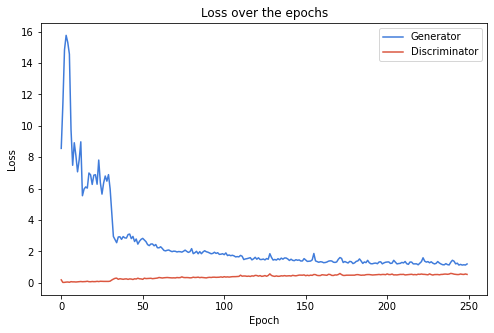

In [8]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(g_loss, color='#407cdb', label='Generator')
ax.plot(d_loss,color='#db5740', label='Discriminator')

ax.legend(loc='upper left')
handles, labels = ax.get_legend_handles_labels()  
lgd = dict(zip(labels, handles))
ax.legend(lgd.values(), lgd.keys())

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over the epochs')
plt.show()


10
(10, 32, 32, 3)


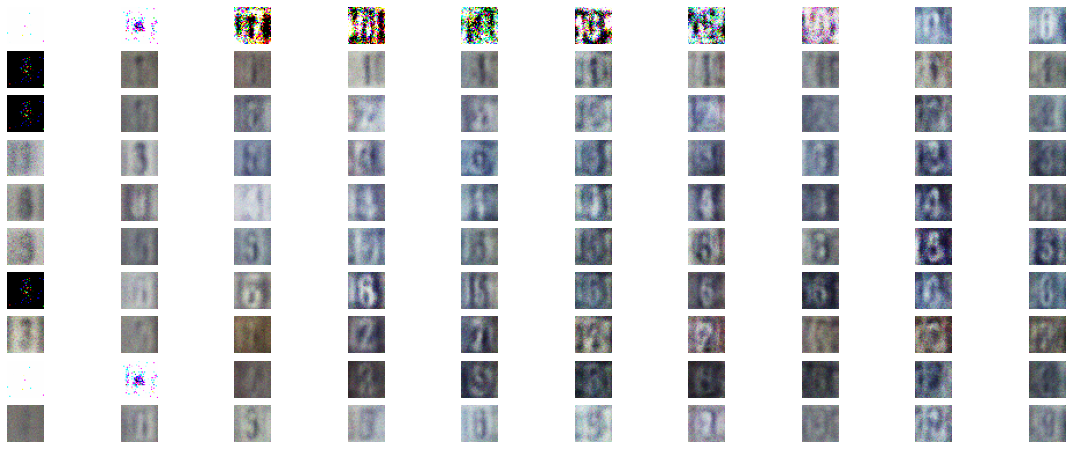

In [9]:
print(len(gen_images))
print(gen_images[0].shape)

fig, axes = plt.subplots(10, 10, figsize=(20, 8))
for i, batch in enumerate(gen_images):
    for j, img in enumerate(batch):
        axes[j][i].axis("off")
        axes[j][i].imshow((img+1)/2) # tanh out has [-1, 1] interval, convert to [0, 1]        

10
(10, 32, 32, 3)


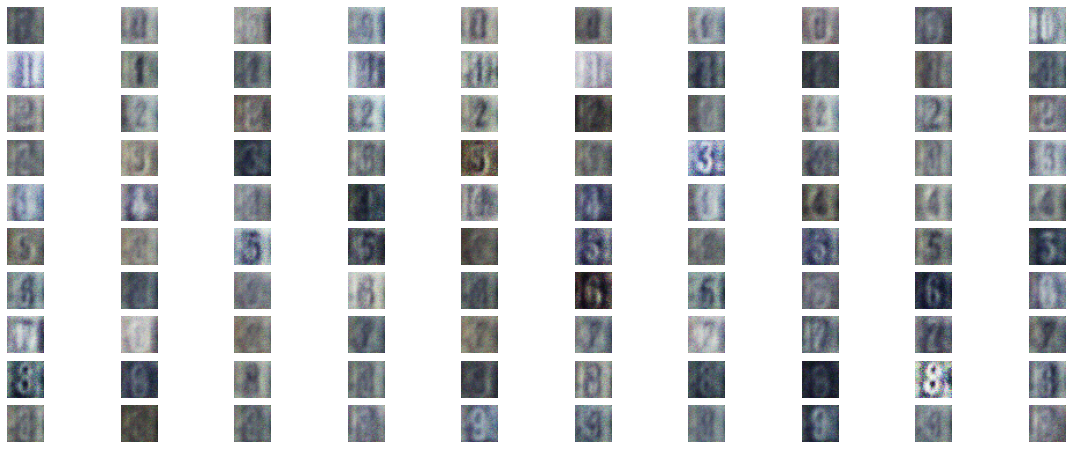

In [10]:
print(len(gen_images))
print(gen_images[0].shape)

gen_images = [generator([tf.random.normal([10, z]), np.array([i]*10)]).numpy().reshape(-1, 32, 32, 3) for i in range(10)]


fig, axes = plt.subplots(10, 10, figsize=(20, 8))
for i, batch in enumerate(gen_images):
    for j, img in enumerate(batch):
        axes[i][j].axis("off")
        axes[i][j].imshow((img+1)/2) # tanh out has [-1, 1] interval, convert to [0, 1]     

##Prazo e Submissão

O trabalho é em dupla ou em trio e a entrega deve ser feita até dia 23/10/2022 (Domingo, 23h59). Apenas uma pessoa da equipe deve submeter o código no Jupyter Notebook.

In [11]:
print(np.arange(0,10))

[0 1 2 3 4 5 6 7 8 9]
